In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [14]:
# We download the data from Yahoo Finance
appl_df = yf.download('VTI', start="2010-01-01", progress=False)

In [15]:
# We set up the Price column to be the next day's open price
appl_df['Price'] = appl_df.Open.shift(-1)

In [16]:
appl_df

,Open,High,Low,Close,Adj Close,Volume,Price
Date,,,,,,,
2010-01-04,56.860001,57.380001,56.840000,57.310001,44.335220,2251500,57.340000
2010-01-05,57.340000,57.540001,57.110001,57.529999,44.505428,1597700,57.500000
2010-01-06,57.500000,57.720001,57.410000,57.610001,44.567329,2120300,57.549999
2010-01-07,57.549999,57.889999,57.290001,57.849998,44.752983,1656700,57.700001
2010-01-08,57.700001,58.049999,57.560001,58.040001,44.899982,1650000,58.299999
...,...,...,...,...,...,...,...
2024-01-22,240.539993,241.399994,240.050003,240.580002,240.580002,3952700,241.020004
2024-01-23,241.020004,241.169998,240.059998,241.020004,241.020004,3015300,242.660004
2024-01-24,242.660004,242.869995,240.850006,240.979996,240.979996,3003000,242.190002


In [17]:
# We calculate the SMA (Simple Moving Average) for a given period
def calc_ma(df, n):
    df['SMA'] = df.Close.rolling(n).mean()

In [24]:
# We build a strategy that buys when the price is above the SMA and sells when the price is below the SMA
# We are long only, so we can only buy when we are not in a position
def backtest(df, n, year_start=2010, year_end=2020):
    df['SMA'] = df.Close.rolling(n).mean()
    # Filter the data to the year range
    df = df[(df.index.year >= year_start) & (df.index.year <= year_end)]
    in_position = False
    profits = []
    for index, row in df.iterrows():
        if not in_position:
            if row.Close > row.SMA:
                buyprice = row.Price
                in_position = True 
        if in_position:
            if row.Close < row.SMA:
               profit = (row.Price - buyprice)/buyprice 
               profits.append(profit)
               in_position = False
    gain = (pd.Series(profits) + 1).prod()   
    return gain

In [27]:
backtest(appl_df, 10, year_start=2019, year_end=2023)

1.3599768229831666

In [20]:
(appl_df.Close.pct_change()+1).prod()

4.224742441378244

In [40]:
# Get the results in a dataframe
results = pd.DataFrame(columns=['n','gain'])
for year in range(2010, 2024):
    for n in np.arange(10,105,5):
        results = pd.concat([results, pd.DataFrame.from_dict({'year': [year],'n':[n],'gain':[backtest(appl_df,n,year_start=year, year_end=year)]})], ignore_index=True)
        if n % 50 == 0:
            print('parameter:' + str(n))
            print(backtest(appl_df,n,year_start=year, year_end=year))
# for n in np.arange(10,205,5):
#     results = pd.concat([results, pd.DataFrame.from_dict({'n':[n],'gain':[backtest(appl_df,n)]})], ignore_index=True)
#     if n % 50 == 0:
#         print('parameter:' + str(n))
#         print(backtest(appl_df,n))

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_15040/1783941183.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame.from_dict({'year': [year],'n':[n],'gain':[backtest(appl_df,n,year_start=year, year_end=year)]})], ignore_index=True)


parameter:50
0.9477939394300724
parameter:100
1
parameter:50
0.9324443159411294
parameter:100
0.9341020756281825
parameter:50
1.037309628879006
parameter:100
1.017757507283721
parameter:50
1.0621918431708621
parameter:100
1.087060711879765
parameter:50
0.9706400891129857
parameter:100
1.0089976438528752
parameter:50
0.8871677689023408
parameter:100
0.9185339129322154
parameter:50
0.9952057573067369
parameter:100
1.0384014499057101
parameter:50
1.005959461413708
parameter:100
1
parameter:50
0.9509995997415931
parameter:100
0.9774004326137197
parameter:50
1.010112606096389
parameter:100
0.9534664781617055
parameter:50
1.1527473053258088
parameter:100
1.0785313864134083
parameter:50
1.05664398603031
parameter:100
1.1297569990403966
parameter:50
0.8525235142440021
parameter:100
0.8008560488049655
parameter:50
1.0114754804505648
parameter:100
1.0490118477592996


In [41]:
results

,n,gain,year
0,10,1.035872,2010.0
1,15,1.131807,2010.0
2,20,1.103988,2010.0
3,25,1.037827,2010.0
4,30,1.093176,2010.0
...,...,...,...
261,80,1.041287,2023.0
262,85,1.052326,2023.0
263,90,1.054862,2023.0
264,95,1.054862,2023.0


<Axes: title={'center': 'gain'}, xlabel='n'>

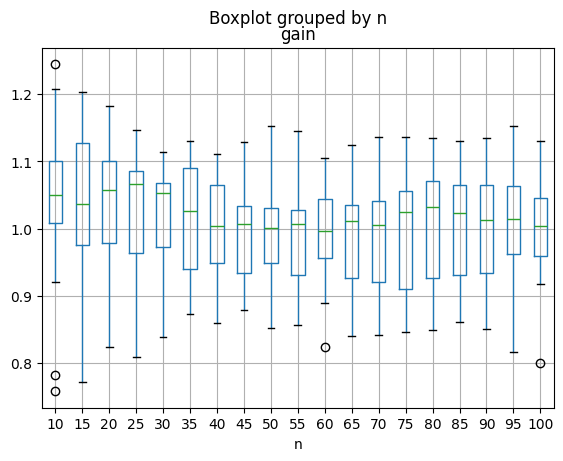

In [42]:
# Plot the results in a box plot with year as third dimension
results.boxplot(column='gain', by='n')

# results.plot(x='n',y='gain')